In [8]:
 !pip install optiland
 import warnings
import numpy as np
from optiland import optic
import pandas as pd
import matplotlib as mpl #Removed extra space before 'import'
mpl.rcParams['font.family'] = 'DejaVu Sans'
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    accuracy_score,
    f1_score
)
from imblearn.over_sampling import SMOTE

from optiland.rays import RealRays
from optiland import optic
from optiland import materials

In [9]:
class InfraredTriplet(optic.Optic):
    """Infrared Air-Spaced Triplet

    Milton Laikin, Lens Design, 4th ed., CRC Press, 2007, p. 54
    """

    def __init__(self):
        super().__init__()

        germanium = materials.IdealMaterial(n=4.002)

        ZnSe = materials.IdealMaterial(n=2.4028)

        self.add_surface(index=0, radius=np.inf, thickness=np.inf)
        self.add_surface(
            index=1,
            radius=10.4578,
            thickness=0.5901,
            material=germanium,
            is_stop=True,
        )
        self.add_surface(index=2, radius=14.1079, thickness=4.3909)
        self.add_surface(index=3, radius=-15.8842, thickness=0.59, material=ZnSe)
        self.add_surface(index=4, radius=-18.2105, thickness=5.6218)
        self.add_surface(index=5, radius=2.5319, thickness=0.3918, material=germanium)
        self.add_surface(index=6, radius=2.4308, thickness=1.3065)
        self.add_surface(index=7)

        self.set_aperture(aperture_type="imageFNO", value=2)

        self.set_field_type(field_type="angle")
        self.add_field(y=0)
        self.add_field(y=2.8)
        self.add_field(y=4)

        self.add_wavelength(value=10.6, is_primary=True)

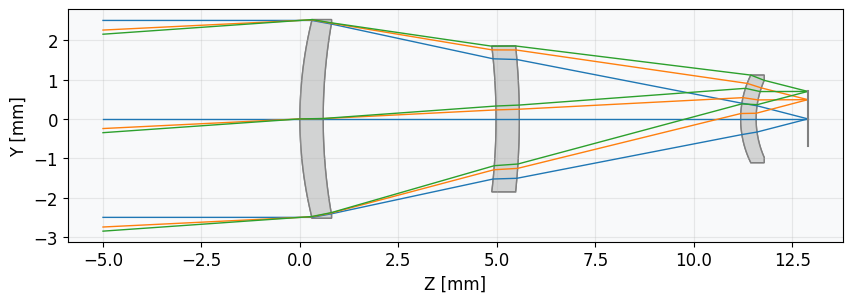

In [10]:
lens = InfraredTriplet()
lens.draw()

In [11]:
def get_random_rays(num_rays, seed=42):
    """Generate random rays."""
    np.random.seed(seed)

    # get random positions
    theta = np.random.uniform(0, 2 * np.pi, size=num_rays)
    r = 15.0 * np.sqrt(np.random.uniform(0, 1, size=num_rays))
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    z = np.full(num_rays, -10.0)  # starting ray point in object space

    # get random directions
    v = np.random.randn(3, num_rays)
    v /= np.linalg.norm(v, axis=0)
    v[2] = np.abs(v[2])  # Ensure positive z-direction
    L, M, N = v

    # define wavelength and intensity as constants
    intensity = np.ones(num_rays)
    wavelength = np.full(num_rays, 0.5876)

    return RealRays(x, y, z, L, M, N, intensity, wavelength)

In [12]:
def trace_random_rays(num_rays):
    # get random rays
    rays_in = get_random_rays(num_rays)

    # build input array
    inputs = np.column_stack([rays_in.x, rays_in.y, rays_in.L, rays_in.M, rays_in.N])

    # trace rays and return
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        rays_out = lens.surface_group.trace(rays_in)

    # build output array - simply checks if ray reached the image plane
    outputs = np.isfinite(rays_out.x)

    # merge into pandas dataframe
    data = pd.DataFrame(inputs, columns=['x', 'y', 'L', 'M', 'N'])
    data['success'] = outputs.astype(int)

    return data

In [22]:
num_rays = 12000

data = trace_random_rays(num_rays)

In [23]:
data.head()

,x,y,L,M,N,success
0,-8.554769,8.604351,-0.282341,0.672750,0.683879,0
1,4.041657,-1.293189,0.868260,-0.005308,0.496080,0
2,-0.833617,-7.336845,-0.021498,0.997385,0.069007,0
3,-10.739042,-7.664908,0.281857,0.542256,0.791527,0
4,6.072569,9.059704,-0.685490,0.445800,0.575643,0


In [24]:
print("Class Distribution:\n", data['success'].value_counts(normalize=True))

Class Distribution:
 success
0    0.99425
1    0.00575
Name: proportion, dtype: float64


We can view the distribution of the data columns using the `describe` method.

In [25]:
data.describe()

,x,y,L,M,N,success
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,-0.017963,0.088696,-0.002180,-0.005845,0.500341,0.005750
std,7.555361,7.545431,0.574320,0.579441,0.289978,0.075614
min,-14.970676,-14.983921,-0.999989,-0.999783,0.000126,0.000000
25%,-6.146130,-5.913076,-0.498174,-0.515086,0.249164,0.000000
50%,-0.019762,0.148173,-0.000131,-0.004185,0.500037,0.000000
75%,6.140817,6.207506,0.496147,0.493583,0.752951,0.000000
max,14.991471,14.985442,0.999615,0.999404,0.999875,1.000000


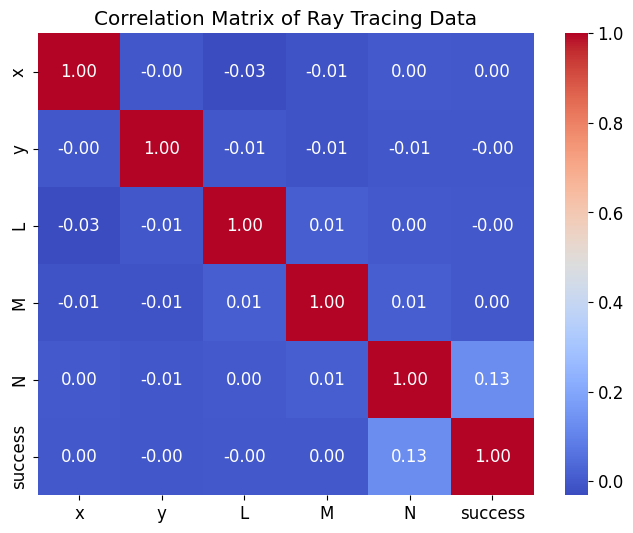

In [26]:
plt.figure(figsize=(8, 6))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Ray Tracing Data')
plt.show()

In [27]:
X = data.drop(columns=['success'])
y = data['success']

In [28]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [29]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [30]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
# Train Logistic Regression model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

In [33]:
from sklearn.svm import SVC

# Train SVM model
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

In [35]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [40]:

from sklearn.metrics import classification_report

# Classification report for Logistic Regression
print("Classification Report for Logistic Regression:\n",
      classification_report(y_test, y_pred_lr))

# Classification report for SVM
print("Classification Report for SVM:\n",
      classification_report(y_test, y_pred_svm))

# Classification report for Random Forest
print("Classification Report for Random Forest:\n",
      classification_report(y_test, y_pred_rf))


Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98      2386
           1       0.11      0.93      0.20        14

    accuracy                           0.96      2400
   macro avg       0.55      0.94      0.59      2400
weighted avg       0.99      0.96      0.97      2400

Classification Report for SVM:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      2386
           1       0.31      0.93      0.46        14

    accuracy                           0.99      2400
   macro avg       0.65      0.96      0.73      2400
weighted avg       1.00      0.99      0.99      2400

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2386
           1       0.59      0.71      0.65        14

    accuracy                           1.00      2400
   mac

In [36]:
#  print accuracy for both the mode

# Calculate and print accuracy scores
lr_accuracy = accuracy_score(y_test, y_pred_lr)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print(f"Logistic Regression Accuracy: {lr_accuracy}")
print(f"SVM Accuracy: {svm_accuracy}")
print(f"Random Forest Accuracy: {rf_accuracy}")


Logistic Regression Accuracy: 0.9554166666666667
SVM Accuracy: 0.9875
Random Forest Accuracy: 0.9954166666666666


Logistic Regression Confusion Matrix:
[[2280  106]
 [   1   13]]

SVM Confusion Matrix:
[[2357   29]
 [   1   13]]

Random Forest Confusion Matrix:
[[2379    7]
 [   4   10]]


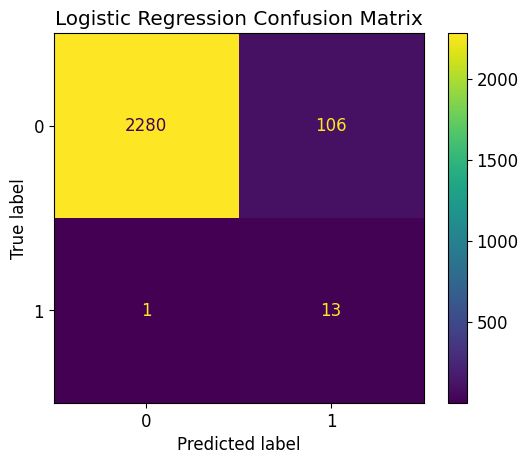

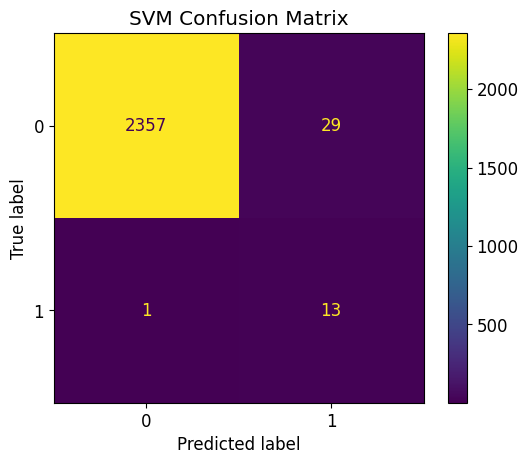

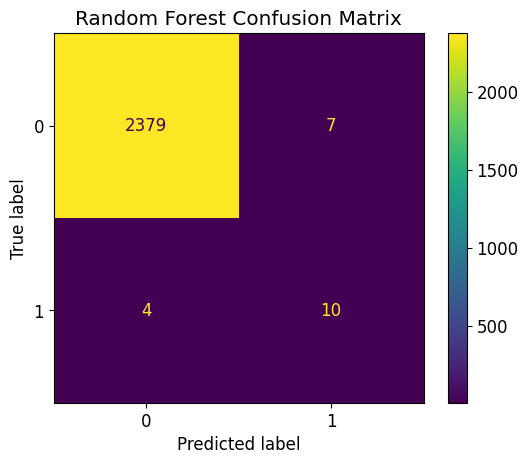

In [37]:
#  confusion matrix for both the model

# Calculate and display confusion matrices
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_rf = confusion_matrix(y_test, y_pred_rf)

print("Logistic Regression Confusion Matrix:")
print(cm_lr)

print("\nSVM Confusion Matrix:")
print(cm_svm)

print("\nRandom Forest Confusion Matrix:")
print(cm_rf)

# Optionally, display confusion matrices visually using ConfusionMatrixDisplay
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=lr_model.classes_)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=svm_model.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_model.classes_)

disp_lr.plot()
plt.title("Logistic Regression Confusion Matrix")
plt.show()

disp_svm.plot()
plt.title("SVM Confusion Matrix")
plt.show()

disp_rf.plot()
plt.title("Random Forest Confusion Matrix")
plt.show()


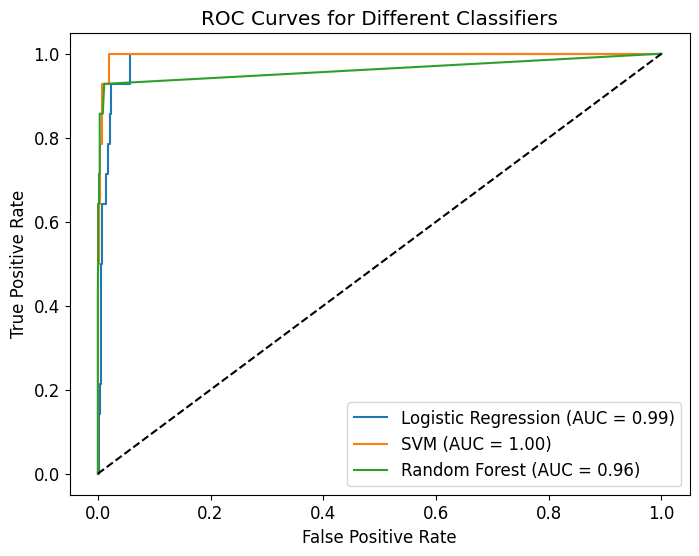

In [38]:

# Calculate ROC curves and AUC scores
lr_probs = lr_model.predict_proba(X_test)[:, 1]
svm_probs = svm_model.decision_function(X_test) # Use decision_function for SVM
rf_probs = rf_model.predict_proba(X_test)[:, 1]

lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

lr_auc = roc_auc_score(y_test, lr_probs)
svm_auc = roc_auc_score(y_test, svm_probs)
rf_auc = roc_auc_score(y_test, rf_probs)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.2f})')
plt.plot(svm_fpr, svm_tpr, label=f'SVM (AUC = {svm_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Classifiers')
plt.legend()
plt.show()


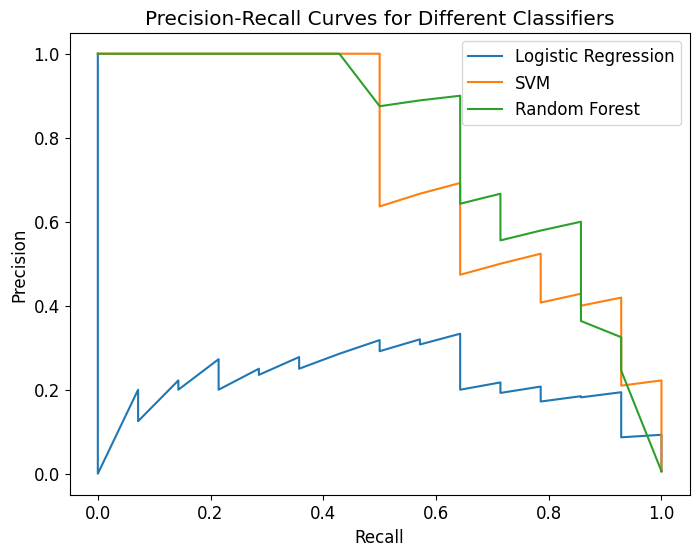

In [39]:

# Calculate precision-recall curves
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
svm_precision, svm_recall, _ = precision_recall_curve(y_test, svm_probs)
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_probs)

# Plot precision-recall curves
plt.figure(figsize=(8, 6))
plt.plot(lr_recall, lr_precision, label='Logistic Regression')
plt.plot(svm_recall, svm_precision, label='SVM')
plt.plot(rf_recall, rf_precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Different Classifiers')
plt.legend()
plt.show()